# Bike Activity Analysis

In [1]:
### Importing required libraries
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
path = "/Users/sreevathsadb/Masters/Project/Data/"
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

# Configuring plotting visual and sizes
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### Loading dataset

In [2]:
path = "/Users/sreevathsadb/Masters/Project/Data/"
path = path + 'dublin_bikes/' # use your path

### Filtering the observations whose year belongs from 2016 to 2021

selected = ['2016', '2017', '2018','2019', '2020','2021']

# Loading the transformed dataset for the particular years due to computation limitations

data = []
for i in range(0,len(selected)):

    temp_data = pd.read_csv(path+str(selected[i])+'.csv', index_col=None, header=0)
    data.append(temp_data)
data = pd.concat(data, axis=0, ignore_index=True)
data.shape

(47292318, 22)

In [3]:
# Drop Duplicates
data.drop_duplicates(keep= 'first',inplace=True)
data.shape

(47292318, 22)

In [4]:
# Filtering the incorrect observations
data = data.drop(data[(data['available_bike_stands'] == 0) & (data['available_bikes'] == 0)].index)
data = data.drop(data[(data['available_bike_stands'] + data['available_bikes']) != data['total_bike_stands']].index)
data.shape

(45150644, 22)

In [5]:
data.columns

Index(['id', 'timestamp', 'total_bike_stands', 'available_bike_stands',
       'available_bikes', 'year', 'month', 'day', 'hour', 'minute', 'weekday',
       'number', 'name', 'latitude', 'longitude', 'holiday', 'season',
       'date_for_merge', 'rain', 'temp', 'wdsp', 'wdsp_classified'],
      dtype='object')

In [6]:
### data transformations for clustering according to different times of data for clustering
# Adopted from : https://github.com/rachelbreslin/dublin_bikes/blob/main/Dublin%20Bikes%20Analysis.ipynb

data['timestamp'] = pd.to_datetime(data['timestamp'])
#data['time'] = data['timestamp'].dt.time
data['date'] = data['timestamp'].dt.date

conditions = [
    (data['weekday'] == "Saturday"),
    (data['weekday'] == "Sunday"),
    ]
values = ["Saturday", "Sunday"]
data['day_type']  = np.select(conditions, values,default="Weekday")

conditions = [
    (data['hour'] < 6),
    (data['hour'] < 11),
    (data['hour'] < 16),
    (data['hour'] < 20),
    (data['hour'] <= 23)
    ]
values = ["Overnight ", "6AM-10AM ", "11AM-3PM ","4PM-7PM ","8PM-11PM "]
data['classified_time'] = np.select(conditions, values,default="Overnight ")
data['cluster_group'] = data['classified_time'] + data['day_type']

In [7]:
# Sort the observations according to station and id
merged_data = data
merged_data = merged_data.sort_values(['id', 'timestamp'])

In [8]:
# Creating a column called bike bike_arr_dep, by subtracting the available bikes from previous timestamp
merged_data['bike_arr_dep'] = merged_data.groupby('id')['available_bike_stands'].diff(-1)

# Creating a column bike arrival, bike departure and interactions

merged_data['bike_arr'] = np.where(merged_data['bike_arr_dep'] > 0, merged_data['bike_arr_dep'], 0)
merged_data['bike_dep'] = np.where(merged_data['bike_arr_dep'] < 0, merged_data['bike_arr_dep'], 0)
merged_data['interactions'] = abs(merged_data['bike_arr']) + abs(merged_data['bike_dep'])

In [9]:
null_data = merged_data[merged_data.isnull().any(axis=1)]
len(null_data)

111

# Exploratory Data Analysis

### Year wise monthly distribution of Bike Activity

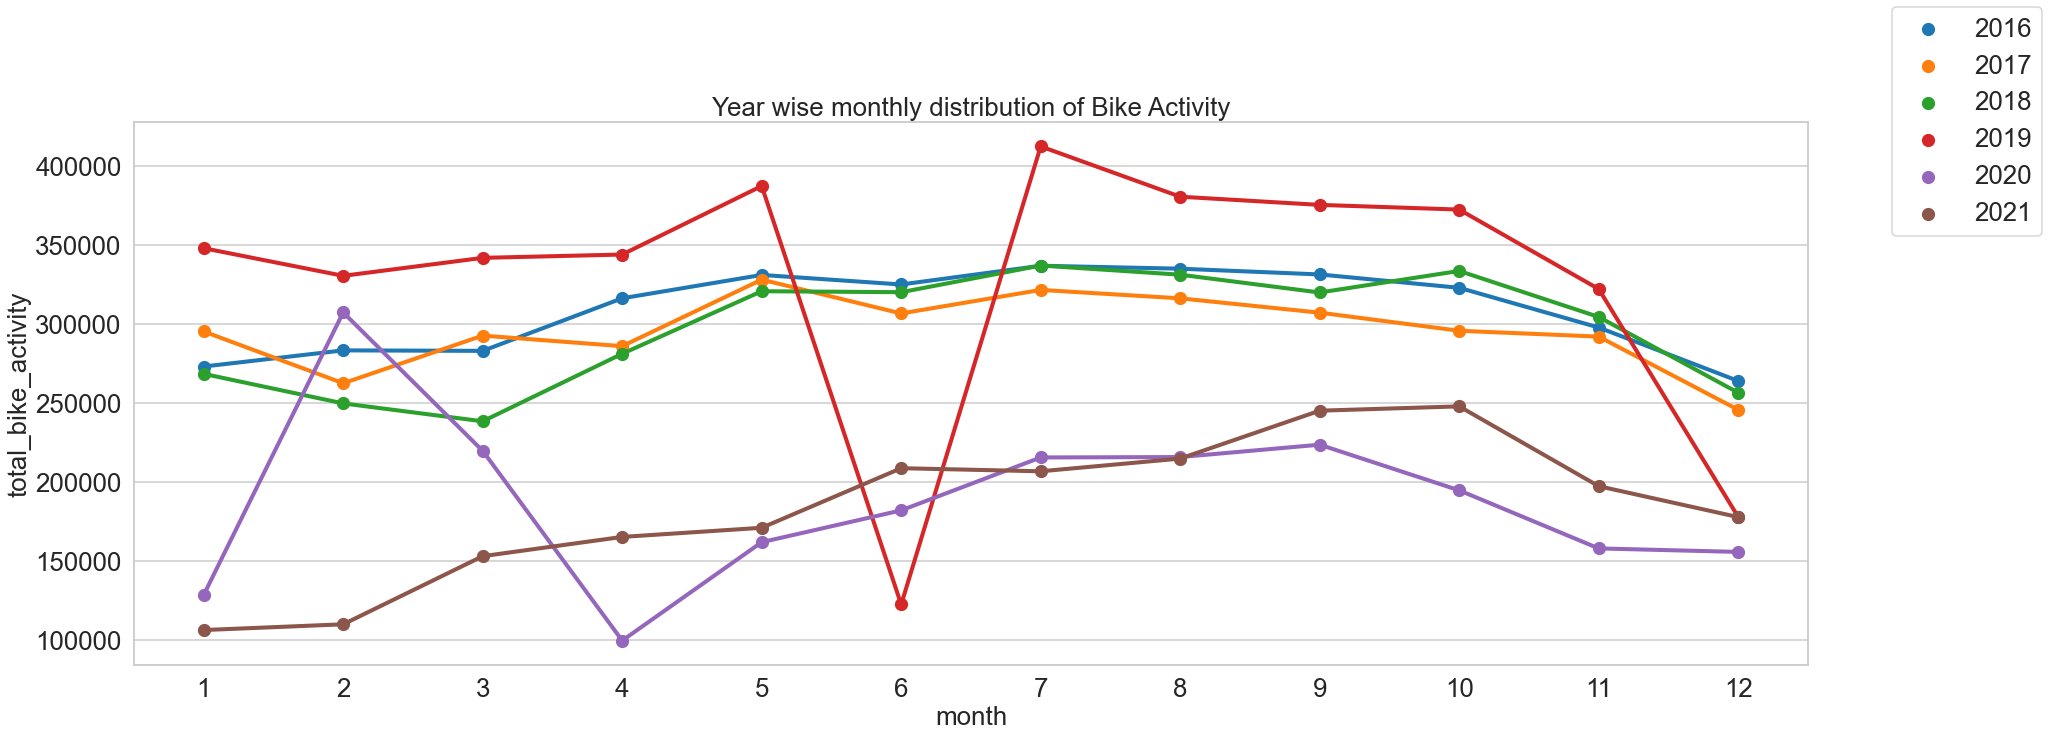

In [10]:
# Visualising the yearly distribution of bike activity in all the stations

bike_activity_year_month = merged_data.groupby(['year','month'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_year_month = bike_activity_year_month.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_year_month = bike_activity_year_month.reset_index(drop=True)
bike_activity_year_month = bike_activity_year_month.sort_values(by=['year','month'])

# Plot 
## From this plot, we analysed impact of Covid-19 on Bike Activity
fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_year_month[['year',
                           'total_bike_activity',
                           'month']],
              x='month',
              y='total_bike_activity',
              hue='year',
              ax=ax)
ax.set(title="Year wise monthly distribution of Bike Activity")

plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Season wise hourly distribution of Bike Activity

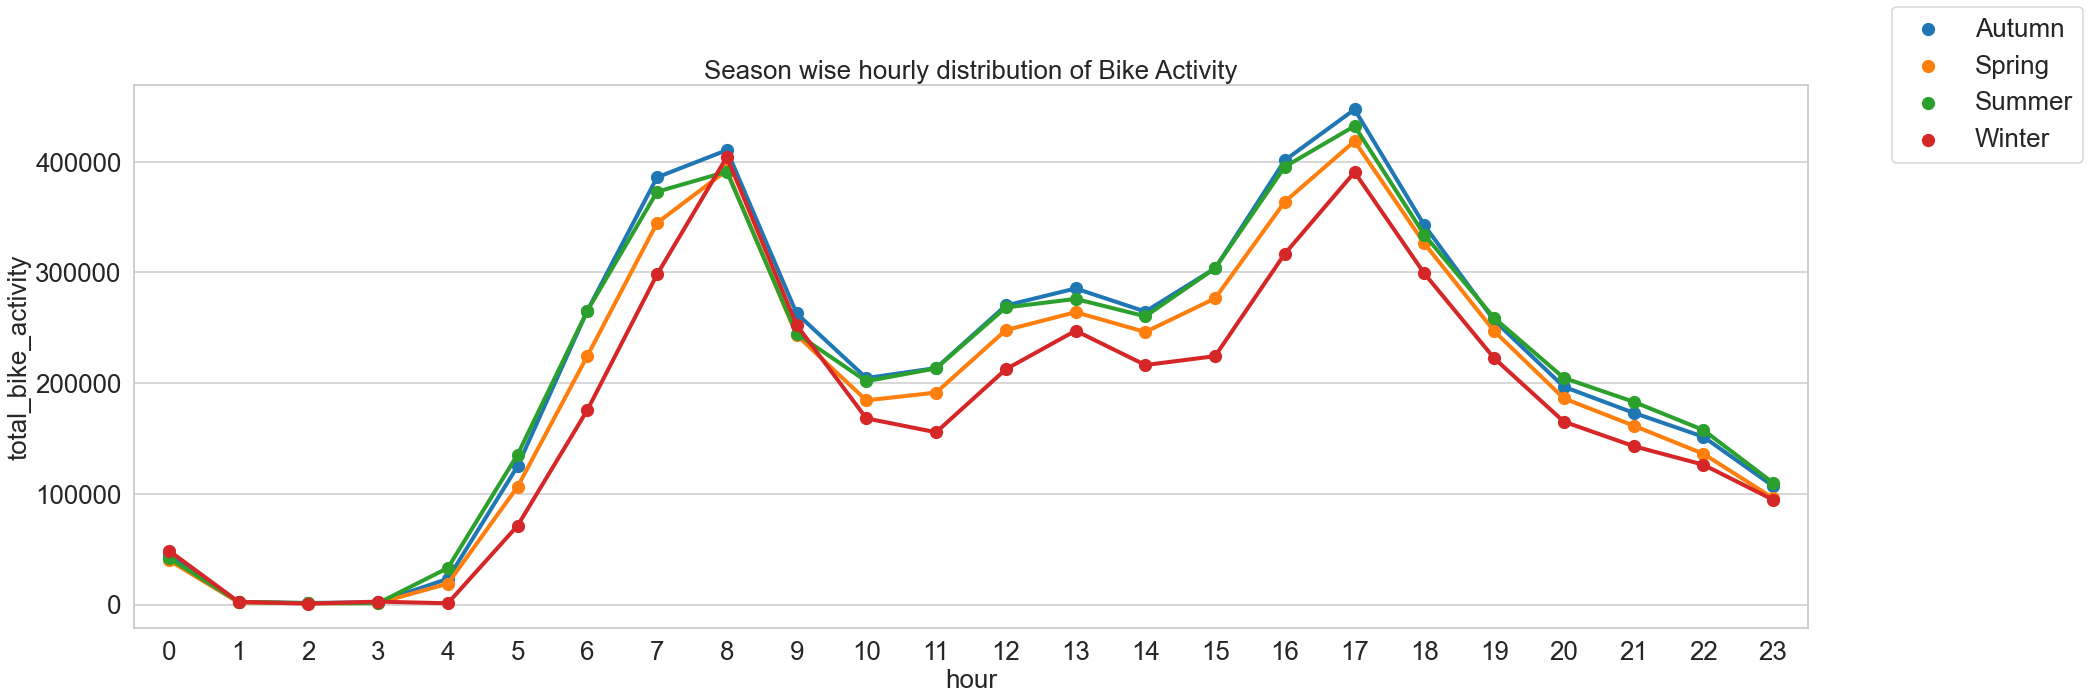

In [11]:
# Visualising the bike activity in all seasons

bike_activity_season_hour = merged_data.groupby(['season','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_season_hour = bike_activity_season_hour.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_season_hour = bike_activity_season_hour.reset_index(drop=True)
bike_activity_season_hour = bike_activity_season_hour.sort_values(by=['season','hour'])

# Plot

fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_season_hour[['hour',
                           'total_bike_activity',
                           'season']],
              x='hour',
              y='total_bike_activity',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of Bike Activity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Weekday wise hourly distribution of Bike Activity

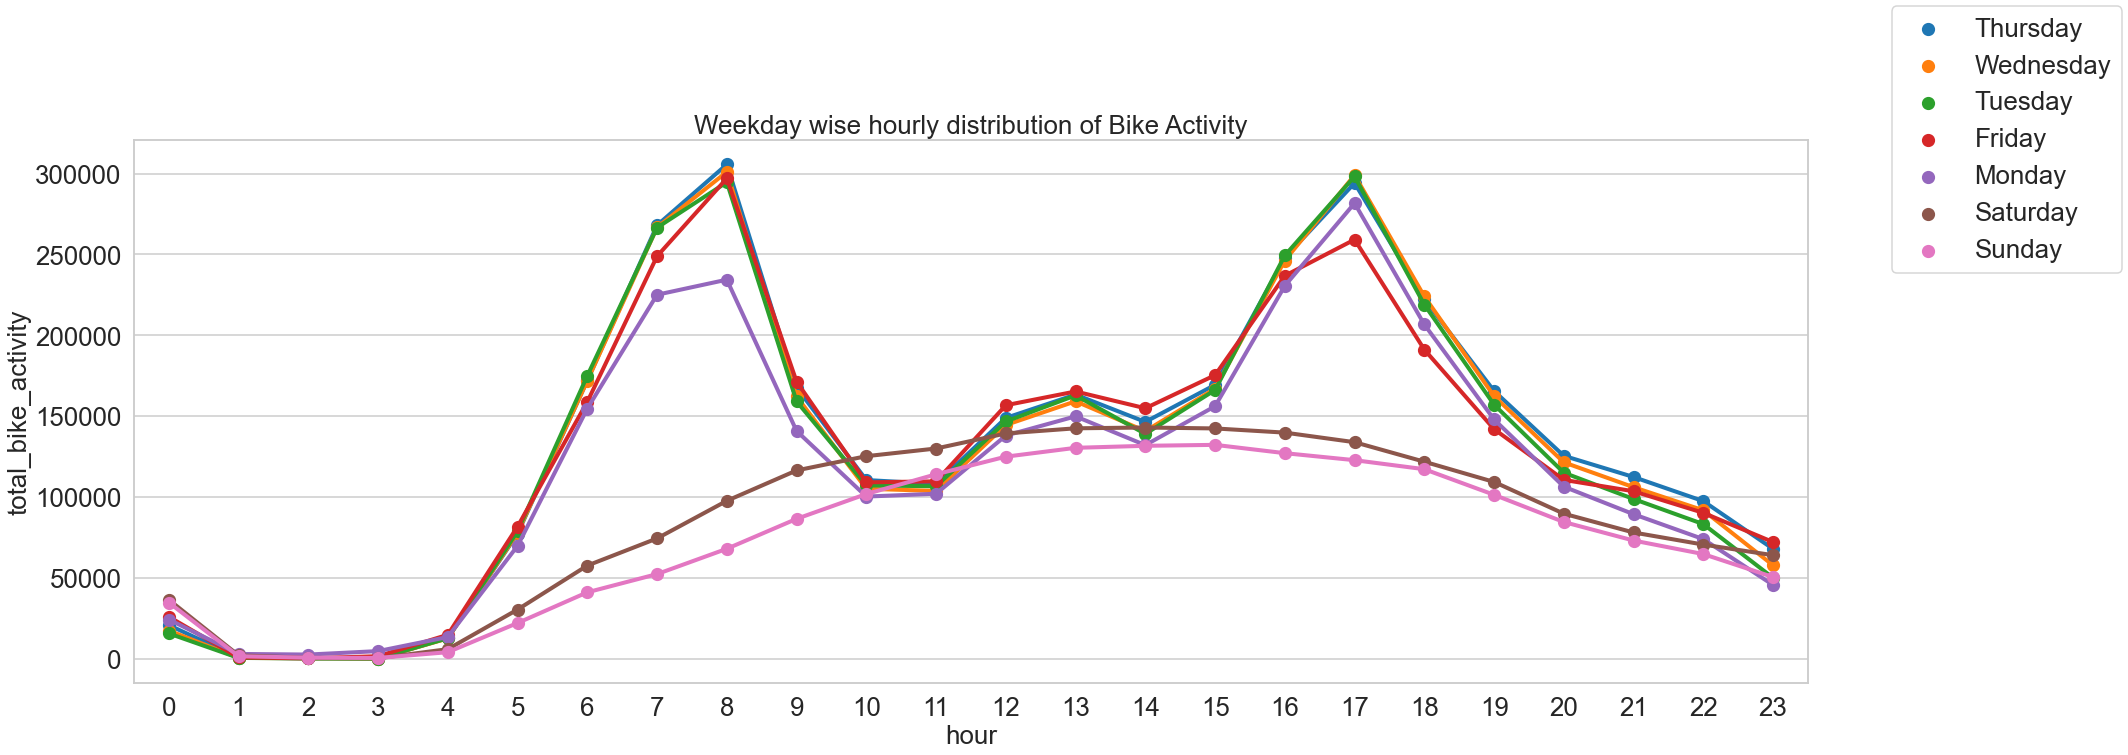

In [12]:
# Visualising the bike activity in all days of the week

bike_activity_weekday_hour = merged_data.groupby(['weekday','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_weekday_hour = bike_activity_weekday_hour.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_weekday_hour = bike_activity_weekday_hour.reset_index(drop=True)

# Plots 
fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_weekday_hour[['hour',
                           'total_bike_activity',
                           'weekday']],
              x='hour',
              y='total_bike_activity',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Bike Activity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Bike Activity on Holidays

Text(0, 0.5, 'Bike Activity')

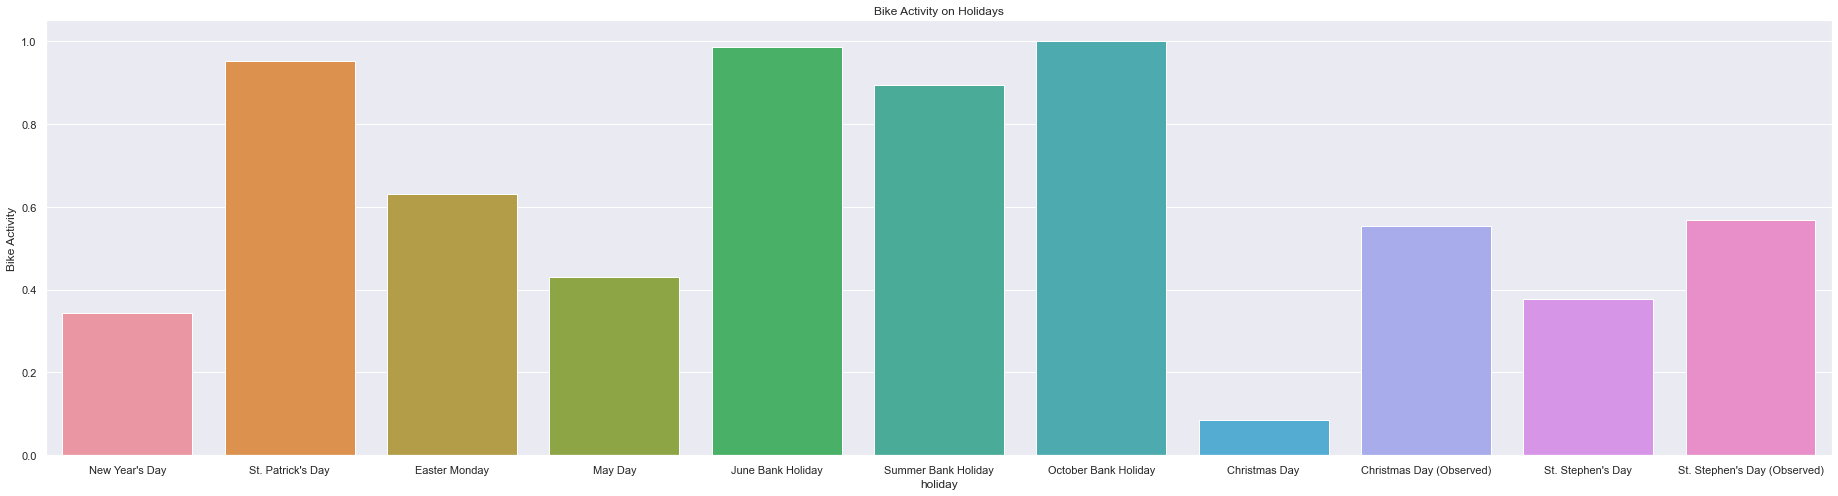

In [13]:
# Visualising the bike activity with respect to several Irish public holidays for 2021 dataset

holiday_data = merged_data[(merged_data['year'] == 2021) & (merged_data['holiday'] != "casual_day")]
holiday_data = holiday_data.groupby(['holiday','month'])['interactions'].sum().reset_index(name ='total_bike_activity')
holiday_data = holiday_data.sort_values(by='month') 

holiday_data['total_bike_activity'] = holiday_data['total_bike_activity']/max(holiday_data['total_bike_activity'])
#plot the results
sns.set(rc={'figure.figsize':(32,8)})
ax = sns.barplot(x='holiday', y='total_bike_activity', data=holiday_data)
ax.set_title('Bike Activity on Holidays')
ax.set_ylabel('Bike Activity')

### Bike Activity Analysis According to Beaufort Wind Scale

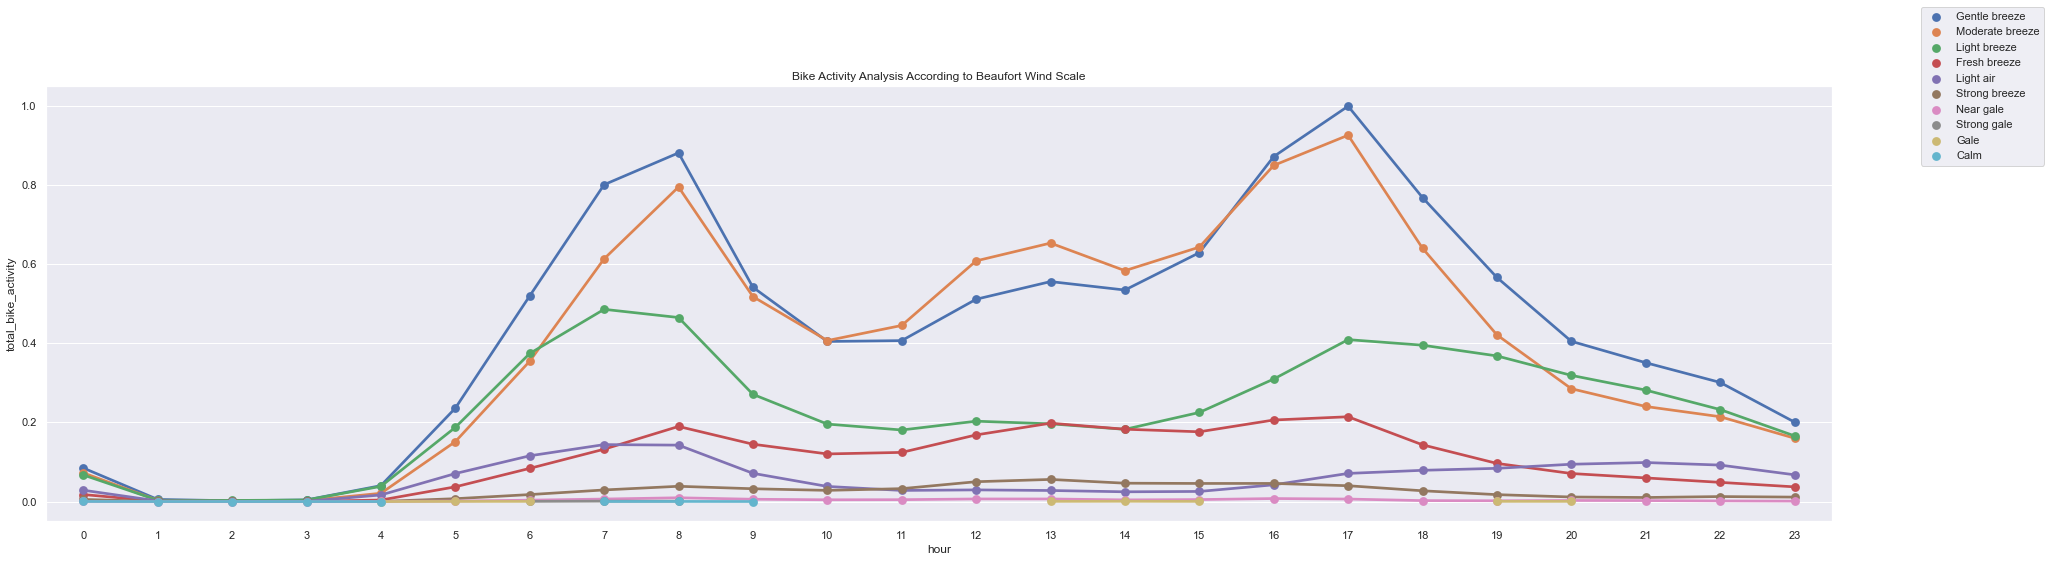

In [14]:
# Visualising the bike avalability according to Beaufort Wind Scale

wind_categories_data = merged_data
wind_categories_data_weekday_hour = wind_categories_data.groupby(['wdsp_classified','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')

wind_categories_data_weekday_hour['total_bike_activity'] = wind_categories_data_weekday_hour['total_bike_activity']/max(wind_categories_data_weekday_hour['total_bike_activity'])

wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.sort_values(by='total_bike_activity',ascending=False) 
wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.reset_index(drop=True)

fig,ax = plt.subplots()
sns.pointplot(data=wind_categories_data_weekday_hour[['hour',
                           'total_bike_activity',
                           'wdsp_classified']],
              x='hour',
              y='total_bike_activity',
              hue='wdsp_classified',
              ax=ax)
ax.set(title="Bike Activity Analysis According to Beaufort Wind Scale")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


# Clustering Analysis 


In [15]:
### Group the stations into clusters according to activity of the bike for analysing the similarities 

## Data Transformation

clustering_df = merged_data[['id', 'name', 'latitude', 'longitude', 'day_type', 'classified_time', 'interactions','cluster_group']]
clustering_df = clustering_df.groupby(['id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['interactions'].mean()
clustering_df  = clustering_df.set_index('id')
#clustering_df.sample(5)

# Pivoting the original dataset (average data stored in a dataframe) for clustering
clustering_df = clustering_df.pivot_table(index= ['name', 'id','latitude', 'longitude'] , columns=['cluster_group'], values='interactions')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('name')
clustering_df = clustering_df.apply(lambda x: x.fillna(x.mean()),axis=0)

clustering_df.sample(5)

# Implementing the Kmeans algorithm on pivit dataset with K = 3 (3 clusters)
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
KM = KMeans(n_clusters=3) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()

# selecting the columns and taking mean of bike activity

locations.columns
col_list = ['11AM-3PM Saturday',
       '11AM-3PM Sunday', '11AM-3PM Weekday', '4PM-7PM Saturday',
       '4PM-7PM Sunday', '4PM-7PM Weekday', '6AM-10AM Saturday',
       '6AM-10AM Sunday', '6AM-10AM Weekday', '8PM-11PM Saturday',
       '8PM-11PM Sunday', '8PM-11PM Weekday', 'Overnight Saturday',
       'Overnight Sunday', 'Overnight Weekday']
locations['rank'] = locations[col_list].mean(axis=1)
# Sort the stations accoding the mean value
locations = locations.sort_values(['rank'])
locations.sample(5)


cluster_group,name,id,latitude,longitude,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster,rank
89,PRINCES STREET / O'CONNELL STREET,33,53.349013,-6.260311,0.854679,0.849293,1.269883,1.044390,0.994071,1.148274,0.918242,0.682325,1.219469,0.660550,0.535409,0.671348,0.153815,0.102256,0.165316,0,0.751288
23,ECCLES STREET,12,53.359246,-6.269779,0.454152,0.376819,0.428194,0.438886,0.386938,0.654935,0.390156,0.269463,0.572775,0.300000,0.276732,0.291885,0.061661,0.056229,0.075739,1,0.335638
49,HATCH STREET,55,53.334030,-6.260714,0.133851,0.131327,0.525195,0.119426,0.115038,0.473742,0.065691,0.039873,0.762577,0.066066,0.062181,0.073045,0.007681,0.009703,0.016475,1,0.173458
11,CHRISTCHURCH PLACE,6,53.343368,-6.270120,0.575679,0.504778,0.525932,0.518276,0.471693,0.670056,0.313841,0.261531,0.491223,0.367570,0.299798,0.348951,0.049628,0.046660,0.033614,2,0.365282
7,BUCKINGHAM STREET LOWER,109,53.353331,-6.249319,0.251159,0.237027,0.263037,0.216043,0.208939,0.372416,0.181445,0.128797,0.353627,0.143430,0.122852,0.193051,0.051639,0.039926,0.067695,1,0.188739


#### Elbow Method

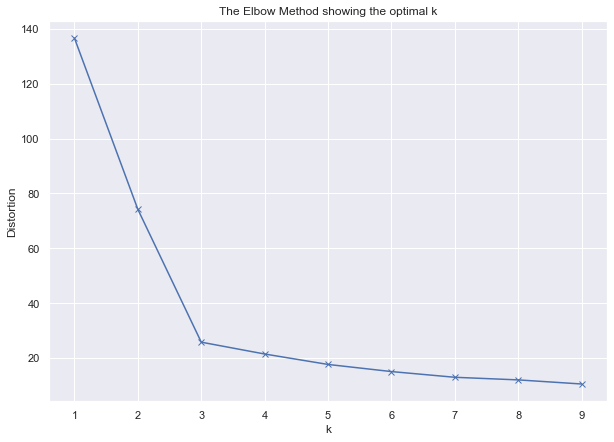

In [16]:
#Visulising through plot for getting optimal K-value
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [17]:
## Visualising the clustered stations geospatially using folium library

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.figsize'] = (10, 8)
colordict = {0: 'red', 1: 'blue', 2: 'green'}
dublin_map = folium.Map([53.350140, -6.266155], zoom_start=13,attr = '© OpenStreetMap contributors, © CartoDB')
for latitude, longitude, Cluster,name in zip(locations['latitude'],locations['longitude'], locations['Cluster'],locations['name']):
    folium.CircleMarker(
        [latitude, longitude],
        color = 'b',
        radius = 5,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9,
        popup=name
        ).add_to(dublin_map)
dublin_map

In [18]:
# Cluster values for each stations is appened to orginal data frame for further analysis

merged_with_clusters = merged_data
cluster_output = locations[['id', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
#del merged_data
merged_with_clusters = pd.merge(merged_with_clusters, cluster_output, on = 'id', how = 'left')


In [19]:
merged_with_clusters.shape

(45150644, 31)

### Bike Activity Analysis On Weekday and Weekend 

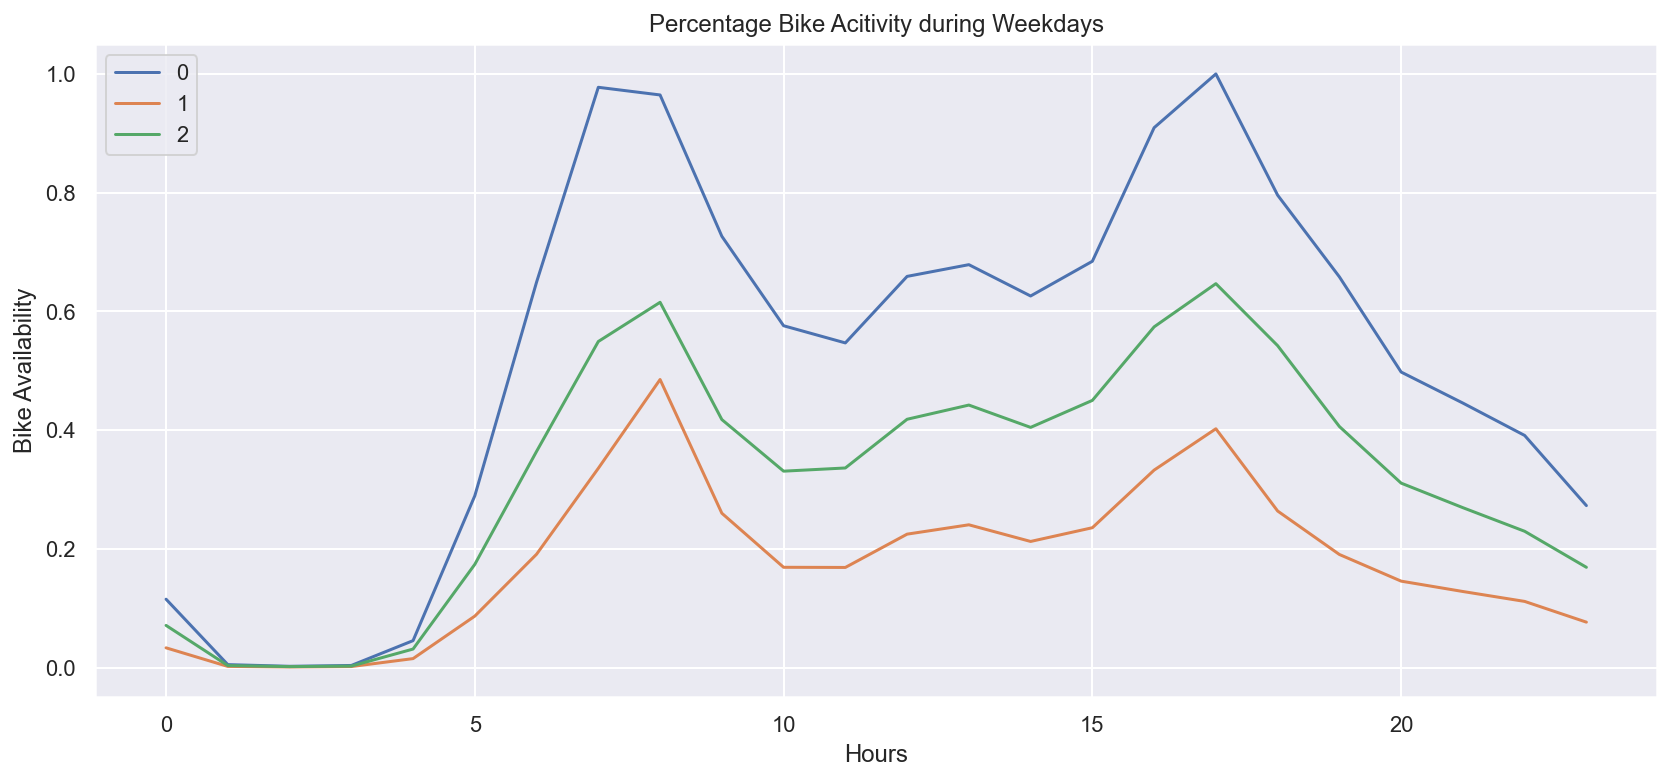

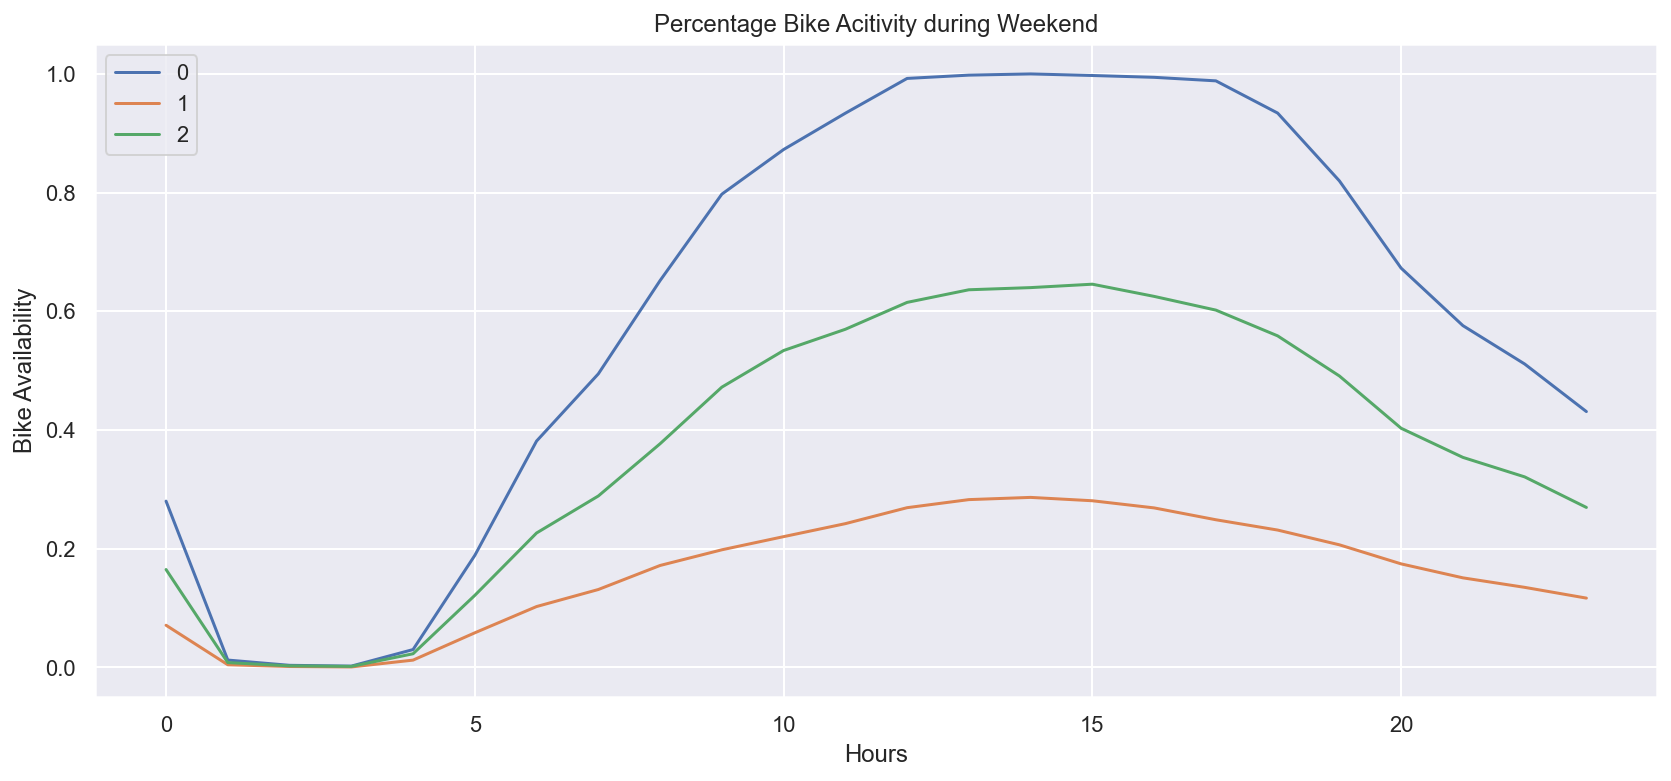

In [20]:
### code adopted from (https://gitlab.cs.nuim.ie/p200120/dublinbikes-analysis/-/blob/master/dublinbikeanalysis.ipynb) on different dataset

## Filter the weekdays and weekends observation to analyse them seperately 
weekly_dataset = merged_with_clusters[(merged_with_clusters['weekday']!= "Saturday") | (merged_with_clusters['weekday']!= "Sunday")]
weekend_dataset = merged_with_clusters[(merged_with_clusters['weekday']== "Saturday") | (merged_with_clusters['weekday']== "Sunday")]

# Group by clusters first, then by hours, taking mean all the interactions(pick and drop) values
# Average all the availability percentage data by grouping them by clusters and then by hours

weekly_dataset = weekly_dataset.groupby(['Cluster','hour'])['interactions'].mean()
weekend_dataset = weekend_dataset.groupby(['Cluster','hour'])['interactions'].mean()

# Normalizing the grouped results
weekly_dataset = weekly_dataset/weekly_dataset.max()
weekend_dataset = weekend_dataset/weekend_dataset.max()

# Plot the results for weekly data
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekly_dataset[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Acitivity during Weekdays')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()

# Plot the results for weekend
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekend_dataset[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Acitivity during Weekend')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()


### Analysis of few Random Stations on Weekdays and Weekends

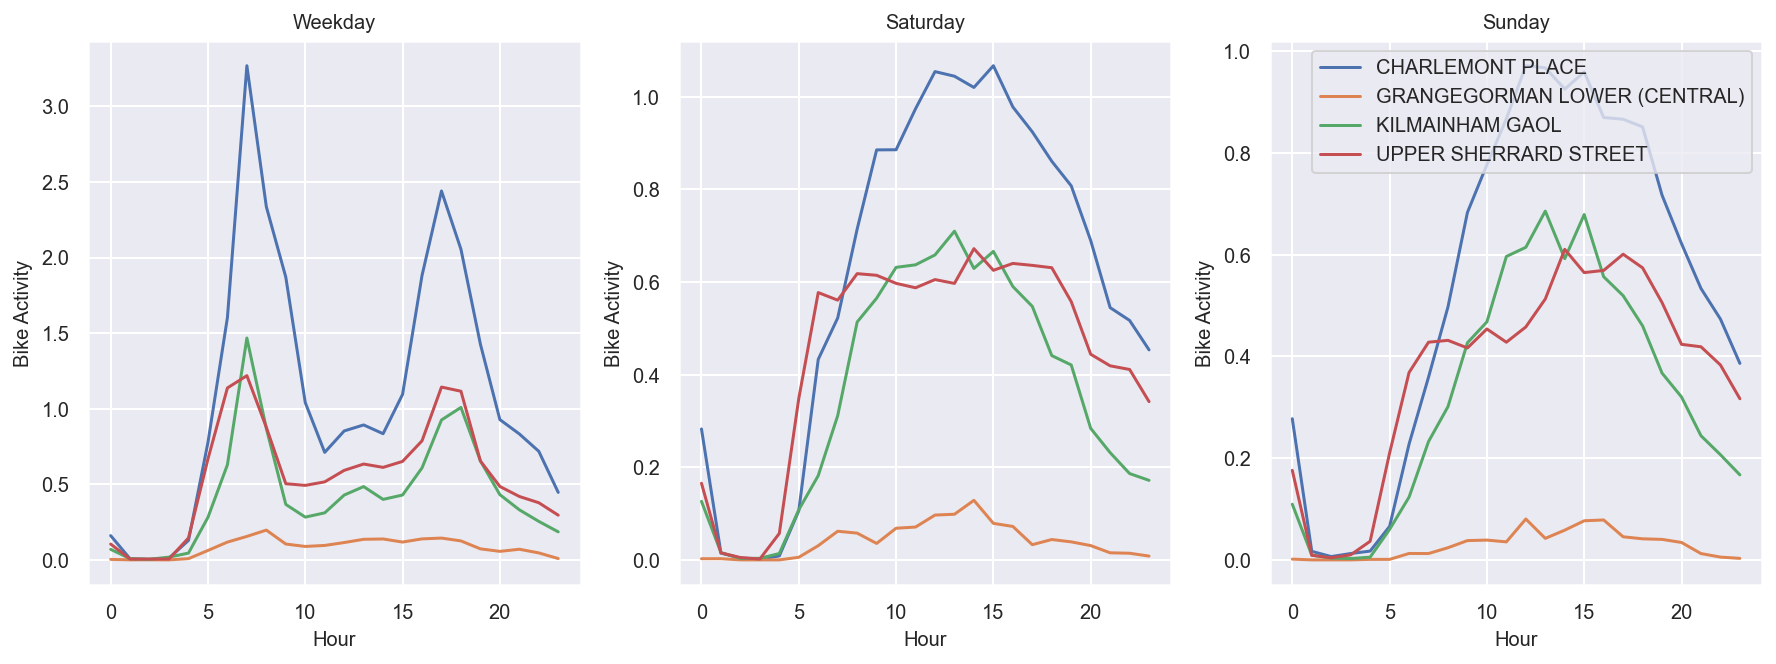

In [21]:
### Code Adopted from (https://github.com/rachelbreslin/dublin_bikes/blob/main/Dublin%20Bikes%20Analysis.ipynb)

linechart_data = merged_with_clusters[['id','name','day_type','hour', 'interactions','Cluster']]

selected_stations = [5,44,97,104]

linechart_data = linechart_data[linechart_data['id'].isin(selected_stations)]

#Weekday
linechart_data_weekday = linechart_data[linechart_data['day_type'] == 'Weekday']
linechart_data_weekday = linechart_data_weekday.groupby(['id','name','hour'])['interactions'].mean()
linechart_data_weekday  = linechart_data_weekday.reset_index()

y1 = linechart_data_weekday['interactions'].values
x1 = linechart_data_weekday['hour'].values
labels1 = linechart_data_weekday['name'].values
colours1 = linechart_data_weekday['name'].values
df1 = pd.DataFrame(dict(x=x1, y=y1, label=labels1))
groups1 = df1.groupby('label')

#Saturday
linechart_data_saturday = linechart_data[linechart_data['day_type'] == 'Saturday']
linechart_data_saturday = linechart_data_saturday.groupby(['id','name','hour'])['interactions'].mean()
linechart_data_saturday  = linechart_data_saturday.reset_index()
y2 = linechart_data_saturday['interactions'].values
x2 = linechart_data_saturday['hour'].values
labels2 = linechart_data_saturday['name'].values
colours2 = linechart_data_saturday['name'].values
df2 = pd.DataFrame(dict(x=x2, y=y2, label=labels2))
groups2 = df2.groupby('label')

#Sunday
linechart_data_sunday = linechart_data[linechart_data['day_type'] == 'Sunday']
linechart_data_sunday = linechart_data_sunday.groupby(['id','name','hour'])['interactions'].mean()
linechart_data_sunday  = linechart_data_sunday.reset_index()
y3 = linechart_data_sunday['interactions'].values
x3 = linechart_data_sunday['hour'].values
labels3 = linechart_data_sunday['name'].values
colours3 = linechart_data_sunday['name'].values
df3 = pd.DataFrame(dict(x=x3, y=y3, label=labels3))
groups3 = df3.groupby('label')

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for name, group in groups1:
    axs[0].plot(group.x, group.y, label=name)
    axs[0].set_title('Weekday')
    axs[0].set_xlabel('Hour')
    axs[0].set_ylabel('Bike Activity')
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)
    
for name, group in groups2:
    axs[1].plot(group.x, group.y, label=name)
    axs[1].set_title('Saturday')
    axs[1].set_xlabel('Hour')
    axs[1].set_ylabel('Bike Activity')
    
    
for name, group in groups3:
    axs[2].plot(group.x, group.y, label=name)
    axs[2].set_title('Sunday')
    axs[2].set_xlabel('Hour')
    axs[2].set_ylabel('Bike Activity')
    axs[2].legend()

plt.show()